In [1]:
import wrds
import pandas as pd
import numpy as np
from scipy import stats
import scipy.linalg as la
from scipy.integrate import quad
from sklearn.metrics import make_scorer
from sklearn import linear_model
from sklearn import model_selection
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
#from statsmodels.regression.rolling import RollingOLS
#import linearmodels as lm
exec(open("/home/amz5/functionsByAnthony.py").read()) # do whatever is in functionsByAnthony.py
from statsmodels.iolib.summary2 import summary_col
import os
wd=os.getcwd()
import random
import warnings

## Part 1 - Finite Sample Bias

In [19]:
alpha = 0
beta = 0.015
sigma_u = 0.053
theta = 0
sigma_v = 0.044
rho = 0.98
#rho_uv=-.8
x0=0
#T=120
B=250
np.random.seed(2021)

def singleb(T, rho_uv):
    sigma_uv=rho_uv*sigma_u*sigma_v

    u, v = np.random.multivariate_normal([0,0], 
                                         [[sigma_u**2,    sigma_uv],
                                          [sigma_uv  ,    sigma_v**2]], T).T
    x_ts=pd.Series(dtype=float)
    r_ts=pd.Series(dtype=float)

    for i in range(0,T):
        if i==0:
            r_ts=r_ts.append(pd.Series([alpha+beta*x0+u[i]], index=[i]))
            x_ts=x_ts.append(pd.Series([theta+rho*x0+v[i]], index=[i]))
        else:
            r_ts=r_ts.append(pd.Series([alpha+beta*x_ts[i-1]+u[i]], index=[i]))
            x_ts=x_ts.append(pd.Series([theta+rho*x_ts[i-1]+v[i]], index=[i]))
    dat=pd.DataFrame(np.array([r_ts,x_ts]).T, columns=['r','x'])
    dat["x_l"]=dat["x"].shift()
    dat=dat.dropna()
    reg=sm.OLS(dat['r'], sm.add_constant(dat['x_l'])).fit()
    return reg.params[1] # line in question
    
def acrossb(T, rho_uv):
    betahats=pd.Series(dtype=float)
    for beta in range(0, B):
        b=singleb(T, rho_uv)
        betahats=betahats.append(pd.Series([b], index=[beta]))
    return [betahats.mean(), np.percentile(betahats, 5), np.percentile(betahats, 95)]

In [20]:
def acrosst(rho_uv):
    allt=pd.DataFrame()
    for t in range(120, 1200+120, 120):
        bbb=acrossb(t, rho_uv)
        tb=pd.DataFrame(np.array([bbb[0],bbb[1],bbb[2]])).T.rename(columns={0:"mean",1:"5th",2:"95th"})
        tb["t"]=t
        allt=allt.append(tb)
    return allt

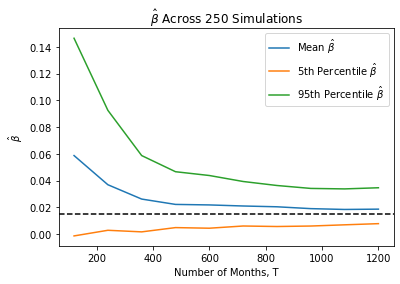

In [21]:
allt=acrosst(-.8)
plot1=plt.figure()
plt.axhline(y=beta, color='k', linestyle='--')

plt.plot(allt["t"], allt["mean"], label="Mean $\\hat{\\beta}$")
plt.plot(allt["t"], allt["5th"], label="5th Percentile $\\hat{\\beta}$")
plt.plot(allt["t"], allt["95th"], label="95th Percentile $\\hat{\\beta}$")

plt.title('$\\hat{\\beta}$ Across 250 Simulations')
plt.xlabel('Number of Months, T')
plt.ylabel('$\\hat{\\beta}$')
plt.legend()

## Part 2 - Effect of residual correlation

In [22]:
rho1=acrosst(-.2)
rho2=acrosst(-.5)
rho3=acrosst(-.8)

/opt/software/Anaconda3/2021.05/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


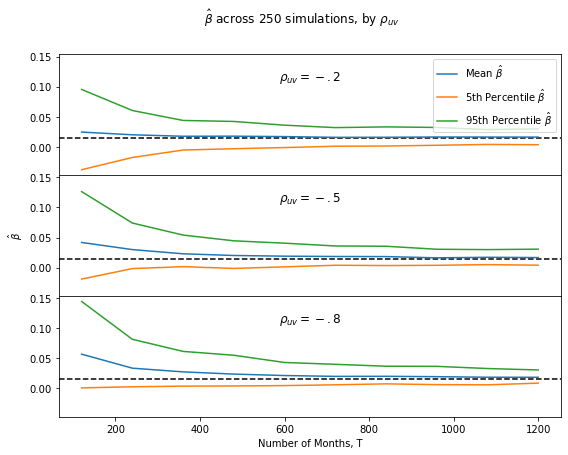

In [23]:
plot2=plt.figure()
ax1=plt.subplot(311) # index 2

plt.axhline(y=beta, color='k', linestyle='--')

#allt=rho1
plt.plot(rho1["t"], rho1["mean"], label="Mean $\\hat{\\beta}$")
plt.plot(rho1["t"], rho1["5th"], label="5th Percentile $\\hat{\\beta}$")
plt.plot(rho1["t"], rho1["95th"], label="95th Percentile $\\hat{\\beta}$")
plt.legend(loc="upper right")
plt.xlabel('Number of Months, T')
ax1.set_title('$\\rho_{uv} = -.2$',x=.5, y=.9, pad=-14)
plt.suptitle("$\\hat{\\beta}$ across 250 simulations, by $\\rho_{uv}$")

ax2=plt.subplot(312, sharey=ax1, sharex=ax1) # index 2
plt.axhline(y=beta, color='k', linestyle='--')
#allt=rho2

plt.plot(rho2["t"], rho2["mean"], label="Mean $\\hat{\\beta}$")
plt.plot(rho2["t"], rho2["5th"], label="5th Percentile $\\hat{\\beta}$")
plt.plot(rho2["t"], rho2["95th"], label="95th Percentile $\\hat{\\beta}$")

plt.xlabel('Number of Months, T')
plt.ylabel('$\\hat{\\beta}$')
ax2.set_title('$\\rho_{uv} = -.5$',x=.5, y=.9, pad=-14)

ax3=plt.subplot(313, sharey=ax1, sharex=ax1) # index 2
plt.axhline(y=beta, color='k', linestyle='--')
#allt=rho3

plt.plot(rho3["t"], rho3["mean"], label="Mean $\\hat{\\beta}$")
plt.plot(rho3["t"], rho3["5th"], label="5th Percentile $\\hat{\\beta}$")
plt.plot(rho3["t"], rho3["95th"], label="95th Percentile $\\hat{\\beta}$")

plt.xlabel('Number of Months, T')
ax3.set_title('$\\rho_{uv} = -.8$',x=.5, y=.9, pad=-14)

plt.subplots_adjust(wspace=0, hspace=0)

plot2.set_size_inches(9,(10/3)*2)

That concludes the required analyses.  In the rest of the notebook I simply write the results to a latex file, using functions in ```'functionsByAnthony.py'```


//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [27]:
#Open the latex output file
tabcount=1
figcount=1
latexopen("PS3.tex", 1)
def ctab():
    global tabcount
    tabcount=tabcount+1
    return
def cfig():
    global figcount
    figcount=figcount+1
    return

latexwrite("PS3.tex",
"\\textbf{Part 1 - Finite Sample Bias} \\\\", pure=True)

latexwrite("PS3.tex", "Figure "+str(figcount), "The figure shows the mean, 5th percentile, and 95th percentile beta estimates "+
"across B=250 simulated samples, generated with $\\rho_{uv}=-.8$.  The true $\\beta$ is indicated with a dashed line."
)


#latexwrite("PS2.tex", "Figure "+str(figcount), "The figure below depicts the distribution of simulated alpha estimates. "+
#    "Returns are simulated such that a fraction $\\lambda$ of the funds/returns are truly skilled ($\\alpha =5$\% per annum).")
latexplot(plot1, "PS3.tex", "plot1", '1cm', scale=1.1/1.2)
cfig()

latexwrite("PS3.tex",
"\\textbf{Part 2 - Effect of residual correlation} \\\\", pure=True)

latexwrite("PS3.tex", "Figure "+str(figcount), "The figure shows the mean, 5th percentile, and 95th percentile beta estimates "+
"across B=250 simulated samples, generated with $\\rho_{uv}=-.8$, $-.5$, or $-.2$.  The true $\\beta$ is indicated with a dashed line."
 )
latexplot(plot2, "PS3.tex", "plot2", '0cm', scale=.7)
latexclose("PS3.tex")

#compile command: pdflatex -pdf PS1.tex